we're going to cover
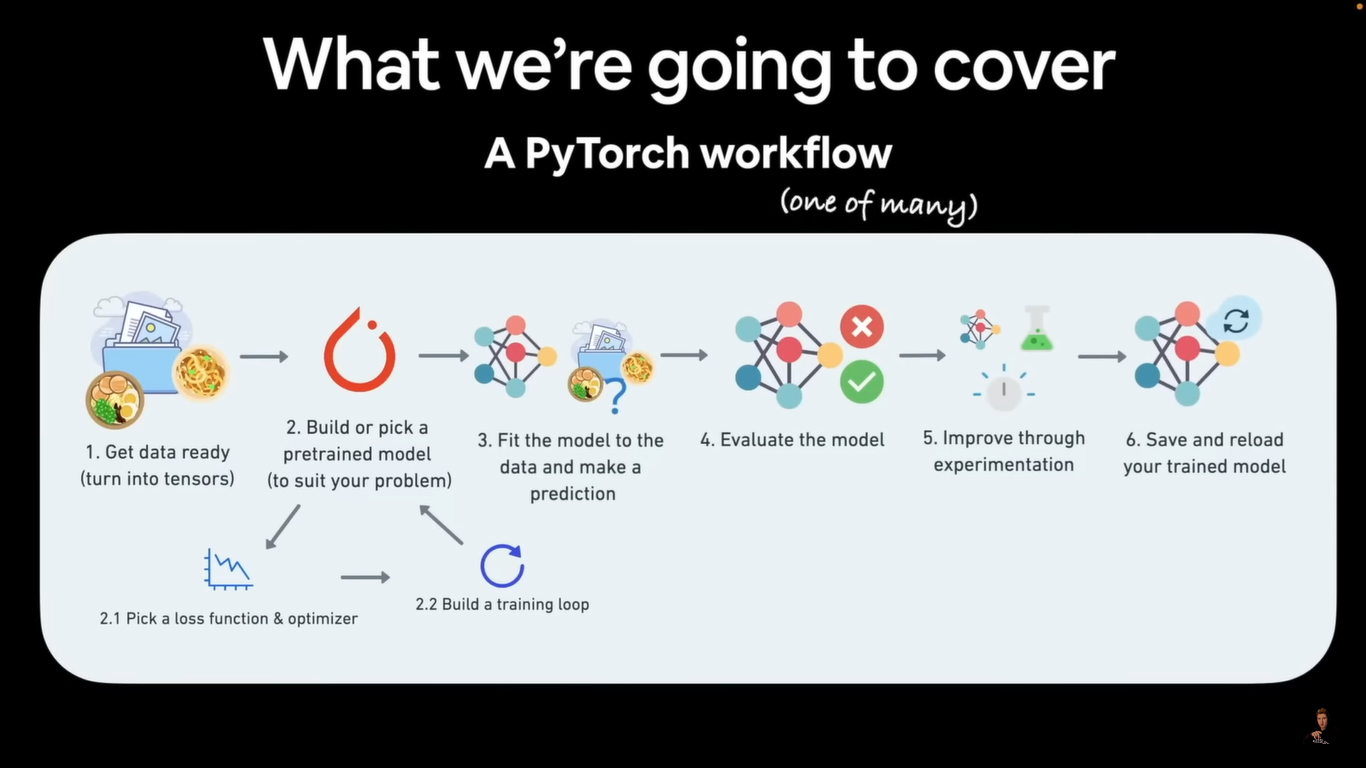

Note: If you're using Google Colab, to setup a GPU, go to Runtime -> Change runtime type -> Hardware acceleration -> GPU.

In [ ]:
# import pytorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'2.0.1+cu118'

In [ ]:
# set of device agnostic code
device = "cuda" if torch.cuda.is_available else "cpu"       # device="cuda" if it's available, otherwise it'll default to device="cpu".
print(f"Using device: {device}")

Using device: cuda


### 1. Data

1.1 Let's create some data.

In [ ]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range value between 0 and 1
start = 0
end = 1
step = 0.02

# Create X and y (feature and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)   # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

1.2 Split data with 80% training data and 20% testing data.

In [ ]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

1.3 Let's visualize them to make sure they look okay

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

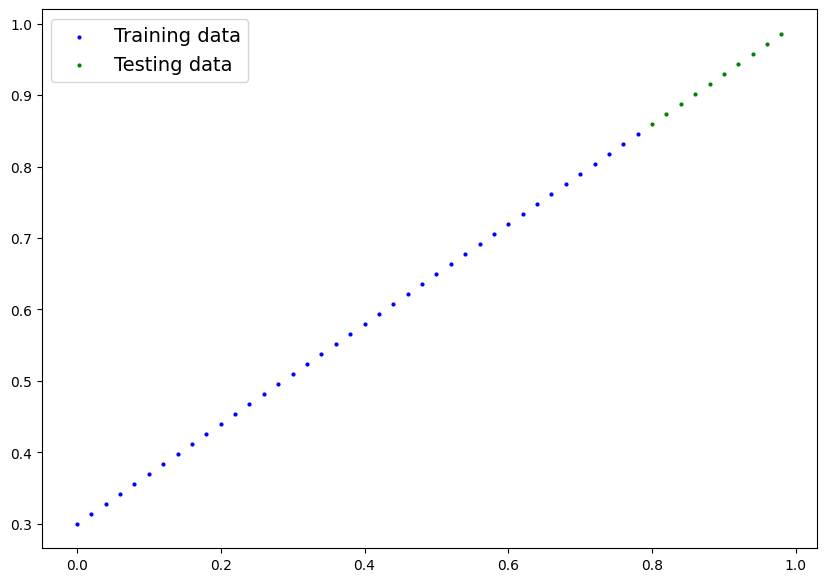

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)


### 2. Building a PyTorch linear model

We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using `nn.Parameter()`, we'll use `nn.Linear(in_features, out_features)` to do it for us.

Where in_features is the number of dimensions your input data has and out_features is the number of dimensions you'd like it to be output to.

In our case, both of these are 1 since our data has 1 input feature (X) per label (y).

In [ ]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device)      # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

### 3. Training


Time to build a training and testing loop.

First we'll need a loss function and an optimizer.

Let's use the same functions we used earlier, `nn.L1Loss()` and `torch.optim.SGD()`.

We'll have to pass the new model's parameters (`model.parameters()`) to the optimizer for it to adjust them during training.

The learning rate of `0.01` worked well before too so let's use that again.

In [ ]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),    # optimize newly created model's parameters
                            lr=0.01)

Beautiful, loss function and optimizer ready, now let's train and evaluate our model using a training and testing loop.

The only different thing we'll be doing in this step compared to the previous training loop is putting the data on the target `device`.

We've already put our model on the target `device` using `model_1.to(device)`.

And we can do the same with the data.

That way if the model is on the GPU, the data is on the GPU (and vice versa).

Let's step things up a notch this time and set `epochs=1000`.

If you need a reminder of the PyTorch training loop steps, see below.

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()   # train mode is on by default after construction

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad optimizer
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()


  ### Testing
  model_1.eval()  # put the model in the evaluation mode for testing (inference)
  # 1. Forward pass
  with torch.inference_mode():
    test_pred = model_1(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


Let's check the parameters our model has learned and compare them to the original parameters we hard-coded.

In [ ]:
# Find our model's learned parameters
from pprint import pprint
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")


The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


Ho ho! Now that's pretty darn close to a perfect model.

Remember though, in practice, it's rare that you'll know the perfect parameters ahead of time.

And if you knew the parameters your model had to learn ahead of time, what would be the fun of machine learning?

Plus, in many real-world machine learning problems, the number of parameters can well exceed tens of millions.





### 4. Making predictions

Now we've got a trained model, let's turn on it's evaluation mode and make some predictions.

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds  = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

Now let's plot our model's predictions.

> Note: Many data science libraries such as pandas, matplotlib and NumPy aren't capable of using data that is stored on GPU. So you might run into some issues when trying to use a function from one of these libraries with tensor data not stored on the CPU. To fix this, you can call `.cpu()` on your target tensor to return a copy of your target tensor on the CPU.

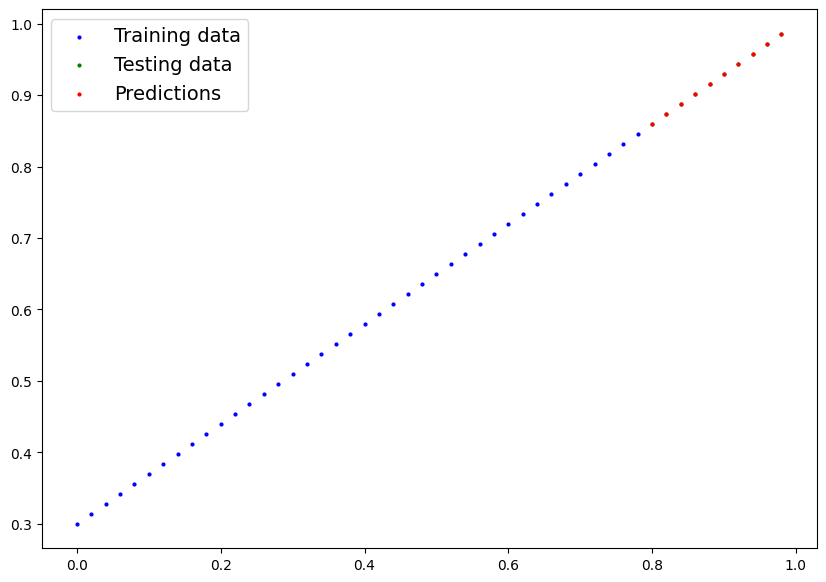

In [ ]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())


Woah! Look at those red dots, they line up almost perfectly with the green dots. I guess the extra epochs helped.

### 5 Saving and loading a model
let's save it to file so it can be used later.

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),      # only saving the state_dict() only saves the models learned parameters
           f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth



And just to make sure everything worked well, let's load it back in.

We'll:

* Create a new instance of the `LinearRegressionModelV2()` class

* Load in the model state dict using `torch.nn.Module.load_state_dict()`

* Send the new instance of the model to the target device (to ensure our code is device-agnostic)

In [ ]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n {loaded_model_1}")
print(f"Model on device:\n {next(loaded_model_1.parameters()).device}")

Loaded model:
 LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
 cuda:0



Now we can evaluate the loaded model to see if its predictions line up with the predictions made prior to saving.

In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')


Everything adds up! Nice!

Well, we've come a long way. You've now built and trained your first two neural network models in PyTorch!